In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from skimage import data, img_as_float
from skimage import exposure

In [2]:
params = 3
amp = 0
ph = 1
mn = 2

n_pixels = 256
pixel_size = 55/1000 #mm
colormap = "bone"#"rainbow"



kernel_cold = np.ones((3,3))/(3*3)
kernel_hot = np.ones((3,3))/(3*3)
#def func(x, a, b, c):
    #return a*np.sin((2*np.pi/16)*x + b) + c

def func(x, amp, phase, mean):
    return mean + amp * np.cos(x + phase)

def wrap_phase(inarray):
    outarray = np.angle(np.exp(1j * inarray))
    return outarray

def fit(ilum_curves,i,j):
    xdata = np.arange(len(names))
    ydata = ilum_curves[i,j]
    ft_ref_curve = np.fft.fft(ydata)
    f0, f1 = ft_ref_curve[0], ft_ref_curve[1]
    f0 = f0.real
    mean_value = f0 / len(images)
    amplitude = 2 * np.abs(f1) / len(images)
    phase_shift = np.angle(f1)
    return np.array([amplitude, phase_shift, mean_value])

def Guess(curve):
    xvall=np.arange(len(curve))
    ff=np.fft.fftfreq(len(xvall), (xvall[1]-xvall[0]))
    Fyy = abs(np.fft.fft(np.array(curve)))
    guess_freq=2*np.pi*abs(ff[np.argmax(Fyy[1:])+1])
    return np.array([np.array(curve).std()*2**0.5, guess_freq, 0, np.array(curve).mean()])

def padding(image,size):
    rows, columns = np.shape(image)[0], np.shape(image)[1]
    padded_image = np.zeros((rows + 2*size, columns + 2*size))
    #padded_image[size:size+rows, size:size+columns] = image
    padded_image[size:-size, size:-size] = image
    return padded_image

def deppading(padded_image,size):
    return padded_image[size:-size, size:-size]

def reduce_dim(imagen, factor):
    filas, columnas = np.shape(imagen)[0], np.shape(imagen)[1]
    new_image = np.zeros((int(filas/factor), int(columnas/factor)))

    for i in range(0,filas,factor):
        for j in range(0,columnas,factor):
            new_image[int(i/factor),int(j/factor)] = np.mean(imagen[i:i+factor, j:j+factor])
    return new_image

           
def preparacion(imagen):
    filas, columnas = np.shape(imagen)[0], np.shape(imagen)[1]

    promedio = np.mean(imagen)
    new_imagen = imagen

    criterio_filas, criterio_columnas = (2.0/3.0)*filas, (2.0/3.0)*columnas

    for i in range(filas):
        if( np.count_nonzero(imagen[i,:]) <  criterio_filas):
            new_imagen[i,:] = promedio*np.ones(filas)
    
    for j in range(columnas):
        if( np.count_nonzero(imagen[:,j]) < criterio_columnas ):
            new_imagen[:,j] = promedio*np.ones(columnas)
    return new_imagen


def interp(imagen):
    factor = 2

    x, y, z = [], [], [] # Creamos nuestros puntos "x", "y", "z"
    
    tamano_matriz = np.shape(imagen)
    filas, columnas = tamano_matriz[0], tamano_matriz[1]
    
    for i in range(filas):
        for j in range(columnas):
            x.append(i)
            y.append(j)
            z.append(imagen[i,j])
    
    x, y, z = np.array(x), np.array(y), np.array(z)
    
    # Aca ya tenemos nuestros datos x,y,z. Ahora solo queda interpolarlos.
    
    grid_x, grid_y = np.mgrid[0:filas-1:factor*filas*1j, 0:columnas-1:factor*columnas*1j] # Creamos la rejilla, tal como se hizo en el primer ejemplo de interpolación en 2D. En este caso exigimos que el nuevo tamaño de la imagen sea de 100x100 y se pone 0:9 dado que los valores de i y j varian desde 0 hasta 9 en principio.  
    
    #print("El tamaño de la matriz nueva será: ", np.shape(grid_x)) # Fijarse que el tamaño de la matriz si es el que queremos
    
    puntos_xy = np.vstack((x,y)).T # Hacemos este paso que ya se había explicado en el ejemplo previo
    
    imagen_nueva = griddata(puntos_xy, z, (grid_x, grid_y), method='cubic') # Hacemos interpolacion cúbica

    imagen_dim_reducida = reduce_dim(imagen_nueva, factor)

    return imagen_dim_reducida



def convolution(image,kernel_cold, kernel_hot, selective=False, stds_cold=1, stds_hot=1):
    excess_cold = int((np.shape(kernel_cold)[0] - 1)/2)
    excess_hot = int((np.shape(kernel_hot)[0] - 1)/2)

    n_pixels_kernel_cold = np.shape(kernel_cold)[0]*np.shape(kernel_cold)[1]
    acceptable_pixels_cold = ((np.shape(kernel_cold)[0]-1)/np.shape(kernel_cold)[0])*n_pixels_kernel_cold
    n_pixels_kernel_hot = np.shape(kernel_hot)[0]*np.shape(kernel_hot)[1]
    acceptable_pixels_hot = ((np.shape(kernel_hot)[0]-1)/np.shape(kernel_hot)[0])*n_pixels_kernel_hot

    mean_image, std_image = np.mean(image), np.std(image)

    minimum_acceptable = mean_image - stds_cold*std_image
    maximum_acceptable = mean_image + stds_hot*std_image
    print("minimum: " ,minimum_acceptable)
    print("maximum: " ,maximum_acceptable)

    if(selective==False):
        padded_image = padding(image,excess_cold)
        padded_rows, padded_columns = np.shape(padded_image)[0], np.shape(padded_image)[1]

        result = np.zeros( (padded_rows, padded_columns) )
        for i in range(excess_cold, padded_rows-excess_cold):
            for j in range(excess_cold, padded_columns-excess_cold):
                if(np.count_nonzero(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) > acceptable_pixels_cold):
                    multiplication = padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]*kernel_cold
                    result[i,j] = np.sum(multiplication)
                elif(np.count_nonzero(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) <= acceptable_pixels_cold):
                    imagen_interp = interp(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1])
                    multiplication = imagen_interp*kernel_cold
                    result[i,j] = np.sum(multiplication)
        result = deppading(result,excess_cold)
        return result

    if(selective==True):

        padded_image_cold = padding(image,excess_cold)
        padded_rows_cold, padded_columns_cold = np.shape(padded_image_cold)[0], np.shape(padded_image_cold)[1]

        result = padded_image_cold
        for i in range(excess_cold, padded_rows_cold-excess_cold):
            for j in range(excess_cold, padded_columns_cold-excess_cold):
                if(result[i,j] <= minimum_acceptable and np.count_nonzero(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) > acceptable_pixels_cold):
                    multiplication = padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]*kernel_cold
                    result[i,j] = np.sum(multiplication)
                elif(result[i,j] <= minimum_acceptable and np.count_nonzero(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) <= acceptable_pixels_cold):
                    imagen_interp = interp(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1])
                    multiplication = imagen_interp*kernel_cold
                    result[i,j] = np.sum(multiplication)

        result = deppading(result,excess_cold)

        padded_image_hot = padding(result,excess_hot)
        padded_rows_hot, padded_columns_hot = np.shape(padded_image_hot)[0], np.shape(padded_image_hot)[1]

        result2 = padded_image_hot

        for i in range(excess_hot, padded_rows_hot-excess_hot):
            for j in range(excess_hot, padded_columns_hot-excess_hot):
                if(result2[i,j] >= maximum_acceptable and np.count_nonzero(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]) > acceptable_pixels_hot):
                    multiplication = padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]*kernel_hot
                    result2[i,j] = np.sum(multiplication)
                elif(result2[i,j] >= maximum_acceptable and np.count_nonzero(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]) <= acceptable_pixels_hot):
                    imagen_interp = interp(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1])
                    multiplication = imagen_interp*kernel_hot
                    result2[i,j] = np.sum(multiplication)

        result2 = deppading(result2,excess_hot)
        return result2

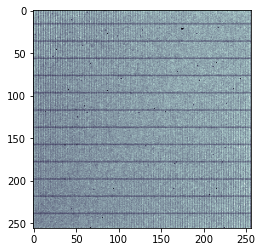

In [29]:
images = []

names = ["FF_sangreM8.txt", "FF_sangreM6.txt", "FF_sangreM4.txt", "FF_sangre0.txt", "FF_sangreP2.txt", 
"FF_sangreP4.txt", "FF_sangreP6.txt", "FF_sangreP8.txt"]

for name in names:
    img = np.rot90(np.genfromtxt("2. FF/"+ name),3)
    images.append(img)

images = np.array(images)
plt.imshow(images[3], cmap="bone")

In [30]:
for img in images: 
    mean = np.mean(img)
    for i in range(256):
        for j in range(256):
            if img[i,j] == 0:
                img[i,j] = mean

In [31]:
def profile_pixel(images,i,j):
    points = []
    for image in images:
        points.append(image[i,j])
    return points


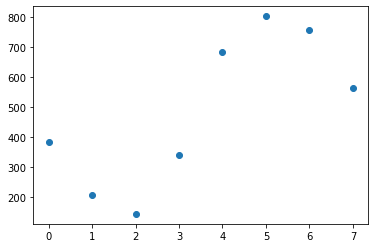

In [32]:
plt.plot(profile_pixel(images,0,0), "o")

In [33]:
ilum_curves_nosample = []

for i in range(256):
    for j in range(256):
        ilum_curves_nosample.append(profile_pixel(images,i,j))

ilum_curves_nosample = np.array(ilum_curves_nosample)
ilum_curves_nosample = ilum_curves_nosample.reshape((256,256,len(names)))

In [34]:
#plt.plot(ilum_curves_nosample.mean(axis=(0,1)), "o")

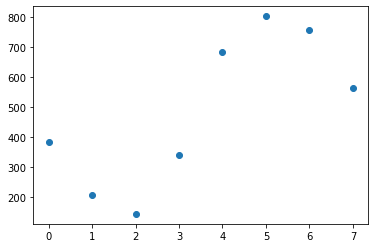

In [35]:
plt.plot(ilum_curves_nosample[0,0], "o")

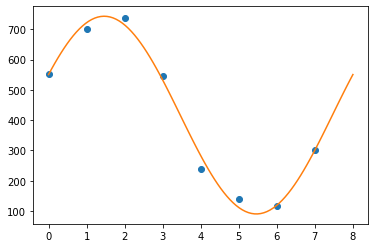

In [36]:
xdata = np.linspace(0, 2*np.pi, 100)

plt.plot(ilum_curves_nosample[0,1], "o")
plt.plot(xdata* len(images) / (2 * np.pi), func(xdata, *fit(ilum_curves_nosample,0,1)))


In [37]:
datos_fits = []

for i in range(256):
    for j in range(256):
        datos_fits.append(fit(ilum_curves_nosample,i,j))

datos_fits = np.array(datos_fits)
datos_fits = datos_fits.reshape((256,256,params)) # numero de parametros de ajuste = 3

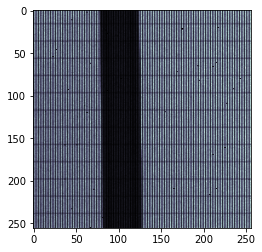

In [46]:
images_sample = []
names = ["RAW_sangreM8.txt", "RAW_sangreM6.txt", "RAW_sangreM4.txt", "RAW_sangreM2.txt", "RAW_sangre00.txt", "RAW_sangreP2.txt", 
"RAW_sangreP4.txt", "RAW_sangreP6.txt", "RAW_sangreP8.txt"]
#names = ["RAW_tubo1_sangreM1.txt", "RAW_tubo1_sangreM2.txt", "RAW_tubo1_sangreM3.txt", "RAW_tubo1_sangreM4.txt", "RAW_tubo1_sangreM5.txt", "RAW_tubo1_sangreM6.txt", 
#"RAW_tubo1_sangreP1.txt", "RAW_tubo1_sangreP2.txt", "RAW_tubo1_sangreP3.txt", "RAW_tubo1_sangreP4.txt", "RAW_tubo1_sangreP5.txt", "RAW_tubo1_sangreP6.txt"]

for name in names:
    img = np.rot90(np.genfromtxt("1. RAW1/"+ name),3)
    #img = np.rot90(np.genfromtxt("1. RAWVIE/"+ name),3)
    images_sample.append(img)

images_sample = np.array(images_sample)
plt.imshow(images_sample[2], cmap="bone")

In [47]:
for img in images_sample: 
    mean = np.mean(img)
    for i in range(256):
        for j in range(256):
            if img[i,j] == 0:
                img[i,j] = mean

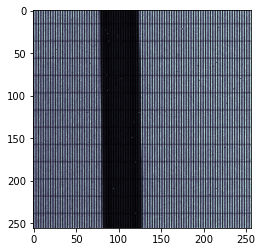

In [48]:
plt.imshow(images_sample[2], cmap="bone")

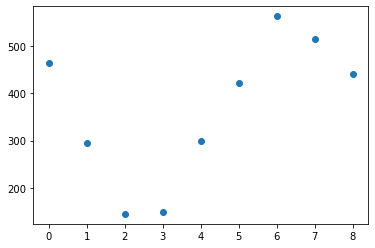

In [49]:
ilum_curves_sample = []

for i in range(256):
    for j in range(256):
        ilum_curves_sample.append(profile_pixel(images_sample,i,j))

ilum_curves_sample = np.array(ilum_curves_sample)
ilum_curves_sample = ilum_curves_sample.reshape((256,256,len(names)))

plt.plot(ilum_curves_sample[100,0], "o")

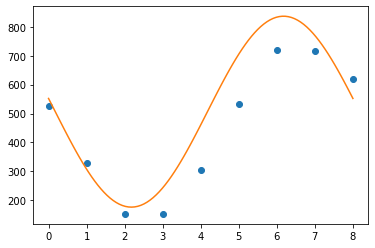

In [50]:
xdata = np.linspace(0, 2*np.pi, 100)

plt.plot(ilum_curves_sample[0,0], "o")
plt.plot(xdata* len(images) / (2 * np.pi), func(xdata, *fit(ilum_curves_sample,0,0)))


In [51]:
datos_fits_s = []

for i in range(256):
    for j in range(256):
        datos_fits_s.append(fit(ilum_curves_sample,i,j))

datos_fits_s = np.array(datos_fits_s)
datos_fits_s = datos_fits_s.reshape((256,256,params)) # numero de parametros de ajuste = 3

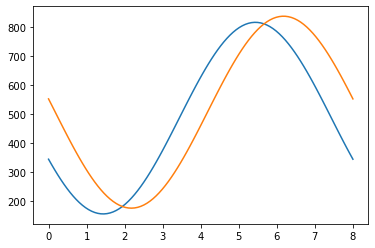

In [52]:
xdata = np.linspace(0, 2*np.pi, 100)
plt.plot(xdata* len(images) / (2 * np.pi), func(xdata, *datos_fits[0,0,:]))
plt.plot(xdata* len(images) / (2 * np.pi), func(xdata, *datos_fits_s[0,0,:]))

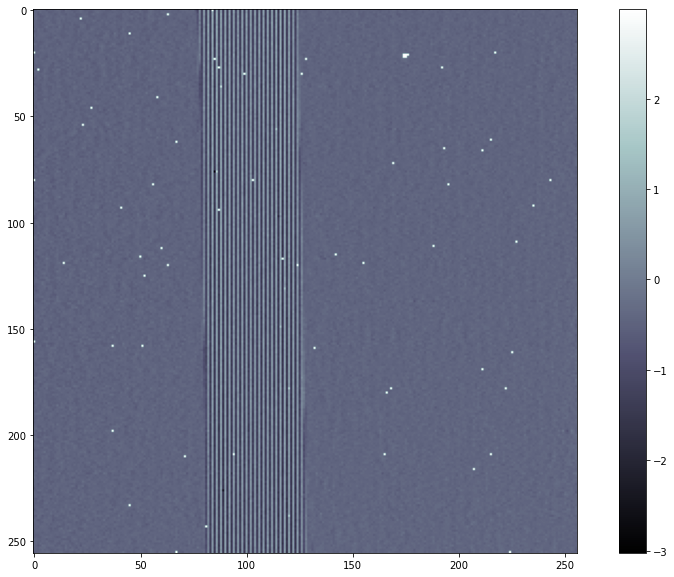

In [53]:
plt.figure(figsize=(15,10))
phase_tot = datos_fits_s[:,:,1] - datos_fits[:,:,1]
phase_tot = wrap_phase(phase_tot)
plt.imshow(phase_tot, cmap="bone")
plt.colorbar()


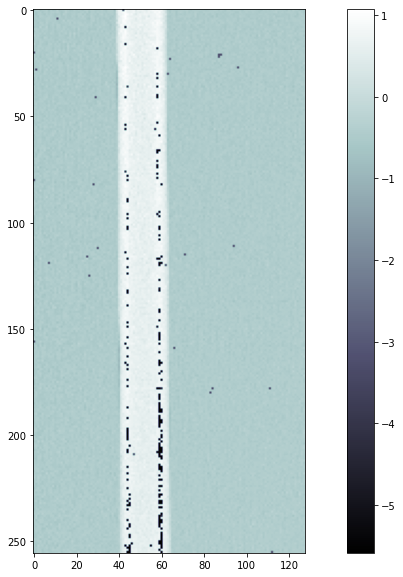

In [54]:
plt.figure(figsize=(15,10))
phase_negative = datos_fits_s[:,::2,1] - datos_fits[:,::2,1]
plt.imshow(phase_negative, cmap="bone")
plt.colorbar()

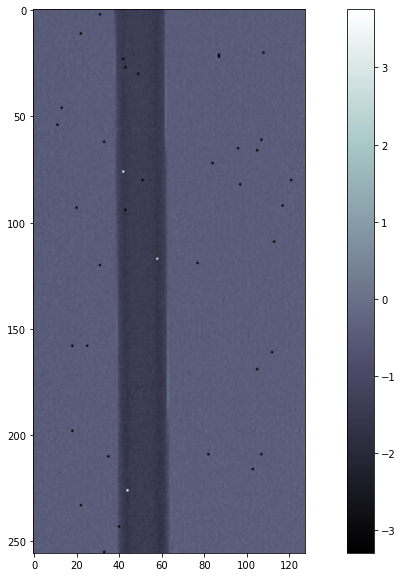

In [55]:

plt.figure(figsize=(15,10))
phase_positive = datos_fits_s[:,1::2,1] - datos_fits[:,1::2,1]
plt.imshow(phase_positive, cmap="bone")
plt.colorbar()


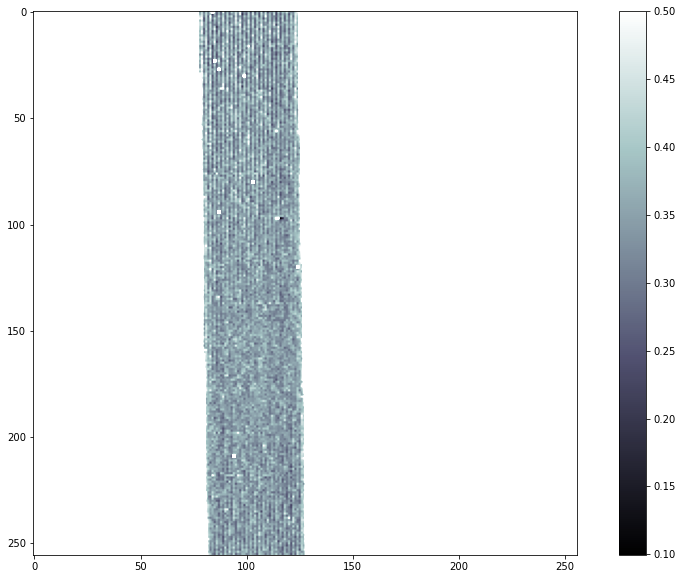

In [56]:
plt.figure(figsize=(15,10))
att = np.abs(datos_fits_s[:,:,0]/datos_fits[:,:,0])
plt.imshow(att, cmap="bone", vmax=0.5)
plt.colorbar()